In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=25

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[1 1 0 2 0 1 1 0 1 1 0 1 0 0 2 0 0 0 0 0 0 0 2 2 0 0 1 0 0 1 2 2]


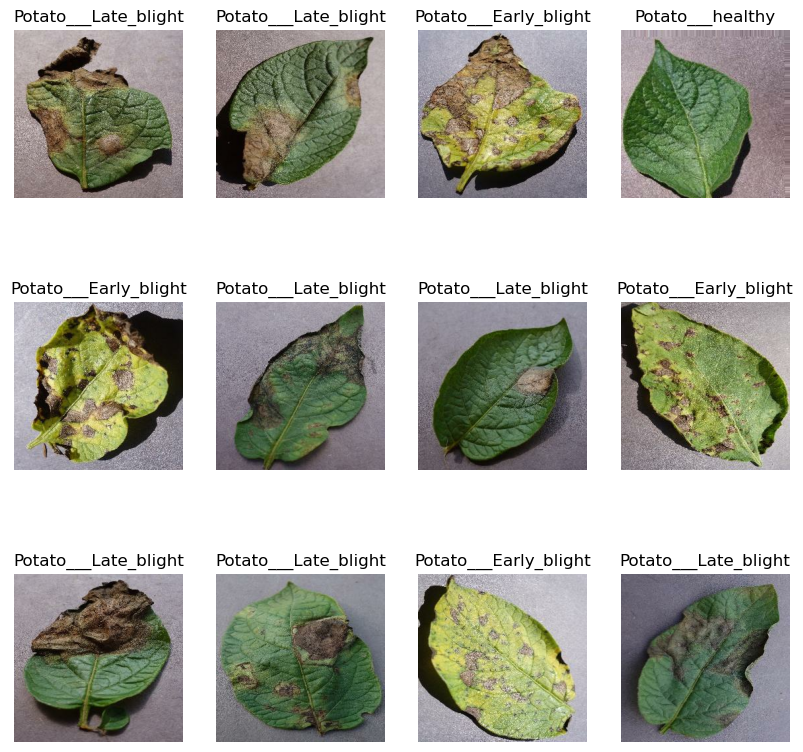

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

37 4 6


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/25
37/37 [==============================] - 46s 1s/step - loss: 1.0185 - accuracy: 0.4653 - val_loss: 0.5376 - val_accuracy: 0.7422
Epoch 2/25
37/37 [==============================] - 46s 1s/step - loss: 0.5330 - accuracy: 0.7542 - val_loss: 0.5379 - val_accuracy: 0.7812
Epoch 3/25
37/37 [==============================] - 45s 1s/step - loss: 0.3763 - accuracy: 0.8551 - val_loss: 0.3249 - val_accuracy: 0.8594
Epoch 4/25
37/37 [==============================] - 46s 1s/step - loss: 0.3095 - accuracy: 0.8881 - val_loss: 0.2767 - val_accuracy: 0.9141
Epoch 5/25
37/37 [==============================] - 46s 1s/step - loss: 0.2654 - accuracy: 0.9000 - val_loss: 0.3095 - val_accuracy: 0.8906
Epoch 6/25
37/37 [==============================] - 48s 1s/step - loss: 0.2040 - accuracy: 0.9297 - val_loss: 0.3276 - val_accuracy: 0.9141
Epoch 7/25
37/37 [==============================] - 47s 1s/step - loss: 0.1794 - accuracy: 0.9331 - val_loss: 0.2461 - val_accuracy: 0.9219
Epoch 8/25
37/37 [==

In [13]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 2s 217ms/step - loss: 0.0930 - accuracy: 0.9688


[0.09302563220262527, 0.96875]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[1.0185405015945435,
 0.5330145955085754,
 0.3762531876564026,
 0.3094679117202759,
 0.26540282368659973,
 0.20396798849105835,
 0.17942972481250763,
 0.1776352971792221,
 0.16174916923046112,
 0.16146153211593628,
 0.15800105035305023,
 0.10060127079486847,
 0.07494115084409714,
 0.09809356927871704,
 0.12528379261493683,
 0.10331999510526657,
 0.05878240987658501,
 0.14754559099674225,
 0.06053883209824562,
 0.05271650850772858,
 0.03747210279107094,
 0.033795688301324844,
 0.054654866456985474,
 0.07738242298364639,
 0.0492527112364769]

In [16]:
history.history['accuracy']

[0.4652542471885681,
 0.7542372941970825,
 0.8550847172737122,
 0.8881356120109558,
 0.8999999761581421,
 0.9296610355377197,
 0.9330508708953857,
 0.9245762825012207,
 0.943220317363739,
 0.948305070400238,
 0.9364407062530518,
 0.9669491648674011,
 0.9796609878540039,
 0.9686440825462341,
 0.9542372822761536,
 0.9635593295097351,
 0.9796609878540039,
 0.9423728585243225,
 0.9813559055328369,
 0.9838982820510864,
 0.9864406585693359,
 0.989830493927002,
 0.9822033643722534,
 0.9754237532615662,
 0.9796609878540039]

In [17]:
history.history['val_loss']

[0.5375920534133911,
 0.5378608703613281,
 0.32487940788269043,
 0.2766682803630829,
 0.30947890877723694,
 0.32756802439689636,
 0.24613524973392487,
 0.335003525018692,
 0.22688740491867065,
 0.14868199825286865,
 0.17793181538581848,
 0.09966957569122314,
 0.05558359622955322,
 0.16858822107315063,
 0.6437633037567139,
 0.11194208264350891,
 0.011447258293628693,
 0.2122536599636078,
 0.3344665765762329,
 0.0091145820915699,
 0.04427655041217804,
 0.25241151452064514,
 0.04775841534137726,
 0.48630213737487793,
 0.05653407424688339]

In [18]:
history.history['val_accuracy']

[0.7421875,
 0.78125,
 0.859375,
 0.9140625,
 0.890625,
 0.9140625,
 0.921875,
 0.90625,
 0.9296875,
 0.9375,
 0.9375,
 0.9609375,
 0.9765625,
 0.953125,
 0.7890625,
 0.96875,
 1.0,
 0.921875,
 0.9140625,
 1.0,
 0.9765625,
 0.9453125,
 0.984375,
 0.890625,
 0.984375]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

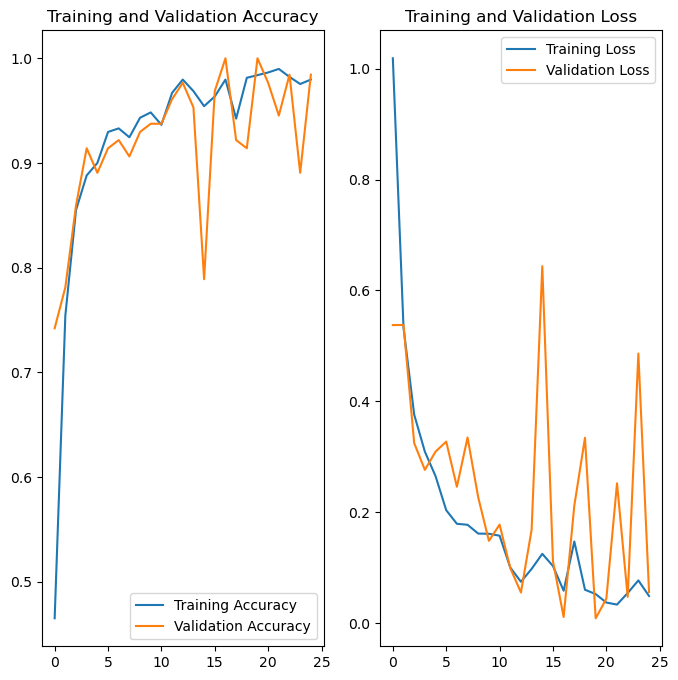

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 249ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 55ms/step


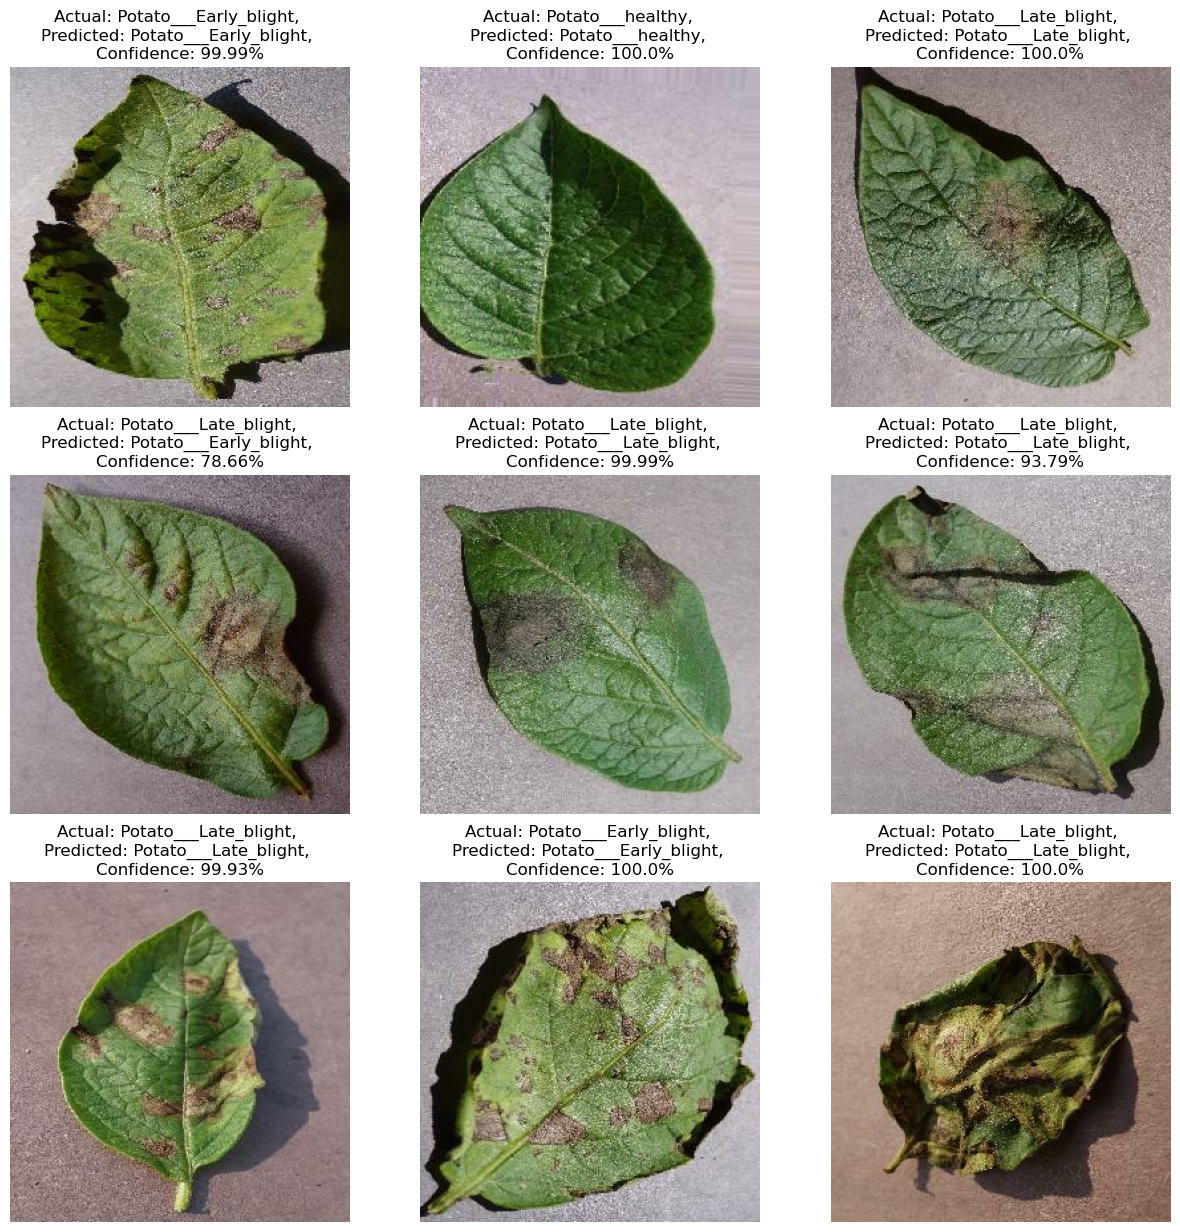

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.90      0.95        62
           2       0.96      1.00      0.98        70

    accuracy                           0.97       192
   macro avg       0.97      0.97      0.97       192
weighted avg       0.97      0.97      0.97       192



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[60,  0,  0],
       [ 3, 56,  3],
       [ 0,  0, 70]])>

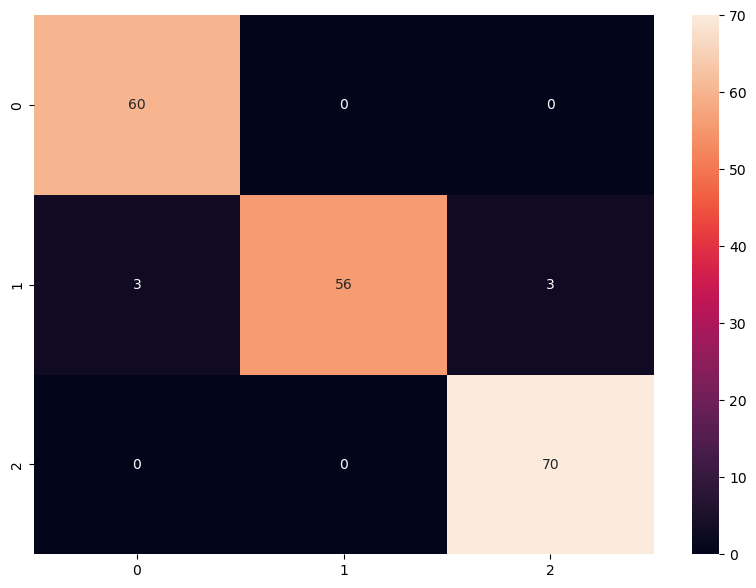

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-2-Epochs25.joblib"
joblib.dump(model, filename)

['Model1-2-Epochs25.joblib']